Сталь – один из важнейших строительных материалов современности. Стальные здания устойчивы к естественному и искусственному износу, что сделало этот материал повсеместно распространенным во всем мире. Чтобы сделать производство стали более эффективным, этот конкурс поможет выявить дефекты.


ссылка на каггл с этим соревнованием - https://www.kaggle.com/c/severstal-steel-defect-detection

### Постановка задачи :

Этот конкурс представляет собой двойной конкурс: классифицируйте тип дефекта стали, а также сегментируйте части изображения, содержащие дефект.



In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

***Загружаем датасет***

In [297]:
data = pd.read_csv('train.csv')

In [298]:
data

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [299]:
data.shape

(7095, 3)

У нас 7095 и три фичи

# Разведочный анализ данных

ClassId
3    5150
1     897
4     801
2     247
Name: count, dtype: int64

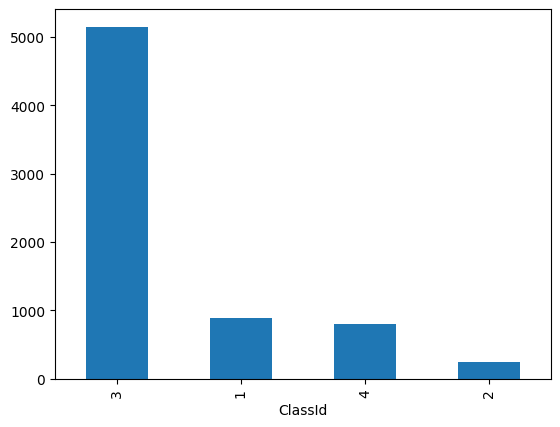

In [300]:
data["ClassId"].value_counts().plot(kind = 'bar')
data["ClassId"].value_counts()

Больше всего меток третьего класса

Перекос данных, поэтому немного ниже выполним аугментацию.

In [301]:
import cv2

***Загружаем фото из zip-архива***

In [302]:
# !unzip "train_images.zip" -d "train_images"

***Плюсом делаем преобразование всех картинок к формату 120х120***

In [303]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(data.values):
    try:
      image=cv2.imread("train_images/{}".format(img),cv2.IMREAD_COLOR)
      image = cv2.resize(image,(120,120))
      l1.append(image)
      l2.append(ClassId)
    except:
      continue

100%|██████████| 7095/7095 [00:02<00:00, 2886.71it/s] 


array([[[  2,   2,   2],
        [  1,   1,   1],
        [  2,   2,   2],
        ...,
        [ 74,  74,  74],
        [ 60,  60,  60],
        [ 64,  64,  64]],

       [[  2,   2,   2],
        [  1,   1,   1],
        [  2,   2,   2],
        ...,
        [ 73,  73,  73],
        [ 66,  66,  66],
        [ 65,  65,  65]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  2,   2,   2],
        ...,
        [ 75,  75,  75],
        [ 65,  65,  65],
        [ 61,  61,  61]],

       ...,

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [114, 114, 114],
        [114, 114, 114],
        [105, 105, 105]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [112, 112, 112],
        [109, 109, 109],
        [108, 108, 108]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [117, 117, 117],
        [109, 109, 109],
        [109, 109, 109]]], dtype=uint8)
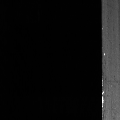

In [304]:
l1[0]

In [305]:
len(l1)

351

Проверка изображений случайной стали, чтобы проверить, дефектна ли она или нет.

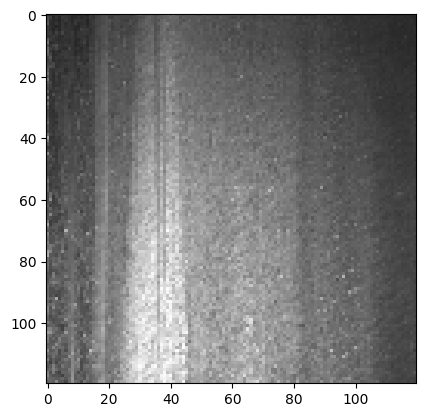

In [306]:
i = 15
plt.imshow(l1[i])

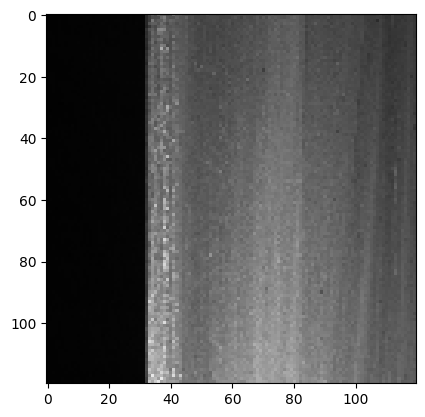

In [307]:
i = 16
plt.imshow(l1[i])

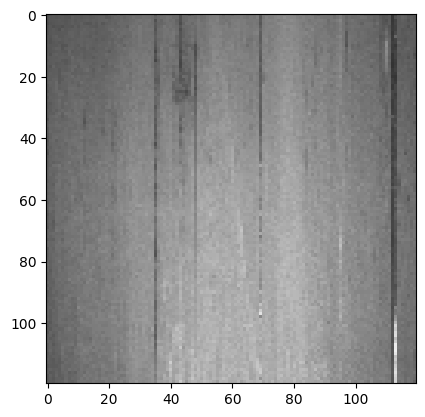

In [308]:
i = 90
plt.imshow(l1[i])

Выполним one-hot кодировку

In [309]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = np.array(y)


In [310]:
X.shape

(351, 120, 120, 3)

In [311]:
y.shape

(351,)

# ***У нас не все фотографии, данных всего 351!***

In [312]:
y

array([2, 2, 2, 0, 2, 3, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2,
       1, 2, 2, 2, 3, 2, 3, 2, 2, 0, 3, 2, 2, 0, 2, 0, 1, 2, 2, 1, 2, 2,
       1, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 0, 2, 3, 2, 2,
       2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 0, 2, 3, 2, 2, 0, 2, 2, 0, 2,
       0, 0, 2, 3, 0, 1, 0, 2, 2, 2, 2, 3, 2, 3, 0, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 0, 3, 0, 2, 2, 1, 0, 2, 3, 2, 2, 2, 3, 0,
       2, 2, 0, 1, 2, 3, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 3,
       0, 1, 2, 3, 2, 2, 0, 0, 1, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 0, 2, 2, 0, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,

***Посмотрим баланс данных (351)***

In [313]:
df = pd.DataFrame(data=y, columns=["ClassId"])
# df = df.convert_dtypes()

In [314]:
df.isnull().sum()

ClassId    0
dtype: int64

ClassId
2    246
0     55
3     31
1     19
Name: count, dtype: int64

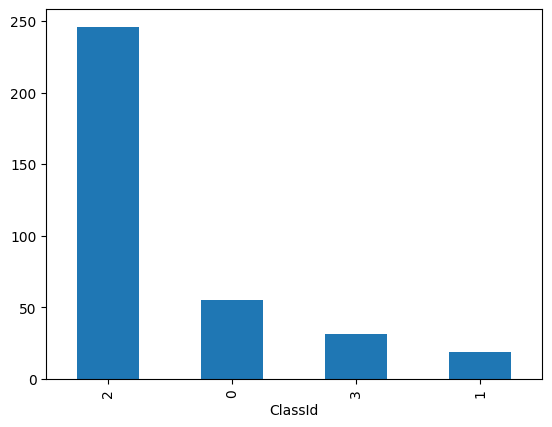

In [315]:
df["ClassId"].value_counts().plot(kind = 'bar')
df["ClassId"].value_counts()

***В этом наборе больше всего меток второго класса***

# Борьба с дибалансом

Для борьбы с дисбалансом выполним случайное сэмплирование

***т.е. выполним аугментацию случайным сэмплированием***

In [316]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X.reshape(X.shape[0],-1)
oversample = RandomOverSampler(sampling_strategy='not majority')
X, y  = oversample.fit_resample(reshaped_X , y)
X = X.reshape(-1,120,120,3)

In [317]:
X.shape

(984, 120, 120, 3)

***Проверим, действительно данные сбалансировались?***

In [318]:
y.shape

(984,)

In [319]:
y

array([2, 2, 2, 0, 2, 3, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2,
       1, 2, 2, 2, 3, 2, 3, 2, 2, 0, 3, 2, 2, 0, 2, 0, 1, 2, 2, 1, 2, 2,
       1, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 0, 2, 3, 2, 2,
       2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 0, 2, 3, 2, 2, 0, 2, 2, 0, 2,
       0, 0, 2, 3, 0, 1, 0, 2, 2, 2, 2, 3, 2, 3, 0, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 0, 3, 0, 2, 2, 1, 0, 2, 3, 2, 2, 2, 3, 0,
       2, 2, 0, 1, 2, 3, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 3,
       0, 1, 2, 3, 2, 2, 0, 0, 1, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 0, 2, 2, 0, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,

***Посмотрим баланс получившихся данных (984)***

In [320]:
df = pd.DataFrame(data=y, columns=["ClassId"])
# df = df.convert_dtypes()

In [321]:
df.isnull().sum()

ClassId    0
dtype: int64

ClassId
2    246
0    246
3    246
1    246
Name: count, dtype: int64

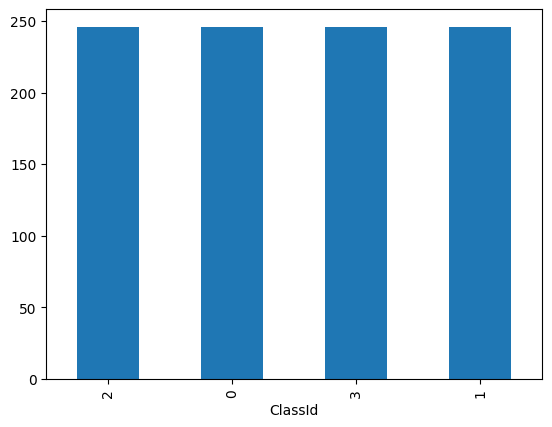

In [322]:
df["ClassId"].value_counts().plot(kind = 'bar')
df["ClassId"].value_counts()

***Теперь данные сбалансированы***<br>
Закодируем дефекты

In [323]:
y = to_categorical(y)

In [324]:
y

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

Разделим на тренировку и валидацию

In [325]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)

In [326]:
print("x_train размер:",X_train.shape)
print("x_test размер:",X_test.shape)
print("y_train размер:",y_train.shape)
print("y_test размер:",y_test.shape)

x_train размер: (787, 120, 120, 3)
x_test размер: (197, 120, 120, 3)
y_train размер: (787, 4)
y_test размер: (197, 4)


# Построение нейронной сети  в 3 слоя и график обучения

### Тест 1

In [327]:
model_1=Sequential()
model_1.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model_1.add(Flatten())
model_1.add(Dense(4,activation="softmax"))

In [328]:
model_1.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [329]:
history = model_1.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
7/7 [==============================] - 2s 101ms/step - loss: 10.2689 - accuracy: 0.3088 - val_loss: 7.7599 - val_accuracy: 0.2741
Epoch 2/10
7/7 [==============================] - 0s 47ms/step - loss: 5.9414 - accuracy: 0.3990 - val_loss: 2.6530 - val_accuracy: 0.4112
Epoch 3/10
7/7 [==============================] - 0s 48ms/step - loss: 1.7132 - accuracy: 0.4282 - val_loss: 1.3772 - val_accuracy: 0.4873
Epoch 4/10
7/7 [==============================] - 0s 50ms/step - loss: 1.0301 - accuracy: 0.5921 - val_loss: 0.9219 - val_accuracy: 0.5888
Epoch 5/10
7/7 [==============================] - 0s 40ms/step - loss: 0.7794 - accuracy: 0.7179 - val_loss: 0.8208 - val_accuracy: 0.6497
Epoch 6/10
7/7 [==============================] - 0s 36ms/step - loss: 0.6590 - accuracy: 0.7751 - val_loss: 0.6698 - val_accuracy: 0.7259
Epoch 7/10
7/7 [==============================] - 0s 37ms/step - loss: 0.5302 - accuracy: 0.8424 - val_loss: 0.5788 - val_accuracy: 0.8629
Epoch 8/10
7/7 [=========

<Axes: title={'center': 'Loss curve'}>

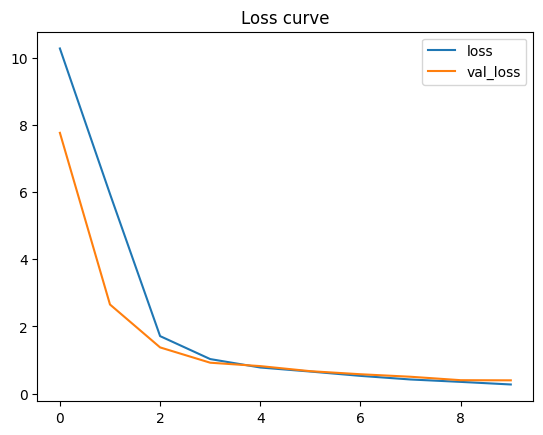

In [330]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

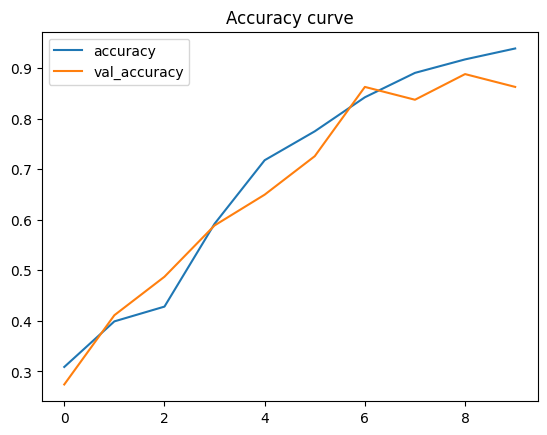

In [331]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

# Построение нейронной сети  в 5 слоев

### Тест 2

In [332]:
model_2=Sequential()
model_2.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model_2.add(MaxPooling2D(pool_size=(3,3)))
model_2.add(Flatten())
model_2.add(Dense(256,activation="relu"))
model_2.add(Dense(4,activation="softmax"))


In [333]:
model_2.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [334]:
history = model_2.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
7/7 [==============================] - 2s 85ms/step - loss: 8.0678 - accuracy: 0.2605 - val_loss: 3.8209 - val_accuracy: 0.3401
Epoch 2/10
7/7 [==============================] - 0s 43ms/step - loss: 3.1489 - accuracy: 0.3799 - val_loss: 1.1901 - val_accuracy: 0.4873
Epoch 3/10
7/7 [==============================] - 0s 37ms/step - loss: 1.3054 - accuracy: 0.4511 - val_loss: 1.2869 - val_accuracy: 0.4975
Epoch 4/10
7/7 [==============================] - 0s 35ms/step - loss: 1.0738 - accuracy: 0.5578 - val_loss: 1.0822 - val_accuracy: 0.4619
Epoch 5/10
7/7 [==============================] - 0s 35ms/step - loss: 0.8985 - accuracy: 0.6099 - val_loss: 0.9269 - val_accuracy: 0.5533
Epoch 6/10
7/7 [==============================] - 0s 34ms/step - loss: 0.8064 - accuracy: 0.6874 - val_loss: 0.8494 - val_accuracy: 0.6650
Epoch 7/10
7/7 [==============================] - 0s 35ms/step - loss: 0.7323 - accuracy: 0.7548 - val_loss: 0.7704 - val_accuracy: 0.7462
Epoch 8/10
7/7 [===========

<Axes: title={'center': 'Loss curve'}>

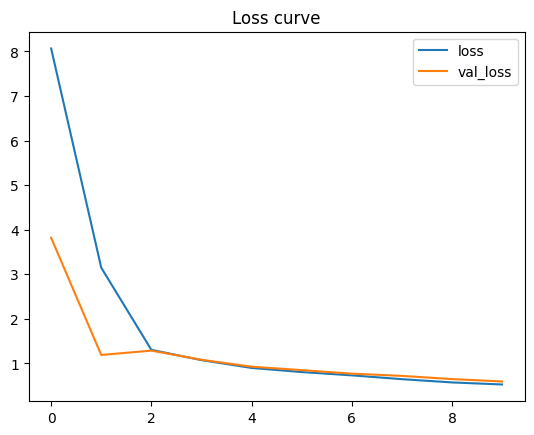

In [335]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

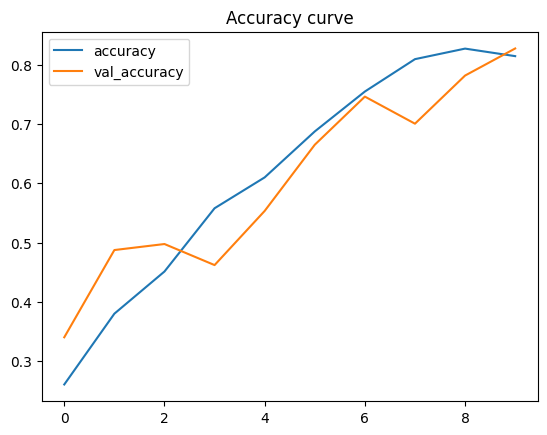

In [336]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

# Построение нейронной сети в 13 слоев и обучение

### Тест 3

In [337]:
model_3=Sequential()
model_3.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model_3.add(MaxPooling2D(pool_size=(3,3)))
model_3.add(Conv2D(64,(3,3),activation="relu"))
model_3.add(MaxPooling2D(pool_size=(3,3)))
model_3.add(Conv2D(64,(3,3),activation="relu"))
model_3.add(MaxPooling2D(pool_size=(4,4)))
model_3.add(Flatten())
model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))
model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))
model_3.add(Dense(256,activation="relu"))
model_3.add(Dense(4,activation="softmax"))

In [338]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)

Сборка и обучение модели

In [339]:
model_3.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [340]:
history = model_3.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
7/7 [==============================] - 3s 108ms/step - loss: 1.3677 - accuracy: 0.2745 - val_loss: 1.3401 - val_accuracy: 0.3553
Epoch 2/10
7/7 [==============================] - 0s 42ms/step - loss: 1.3316 - accuracy: 0.3685 - val_loss: 1.2911 - val_accuracy: 0.4112
Epoch 3/10
7/7 [==============================] - 0s 40ms/step - loss: 1.2685 - accuracy: 0.4295 - val_loss: 1.2010 - val_accuracy: 0.4772
Epoch 4/10
7/7 [==============================] - 0s 44ms/step - loss: 1.1706 - accuracy: 0.4841 - val_loss: 1.0843 - val_accuracy: 0.5025
Epoch 5/10
7/7 [==============================] - 0s 43ms/step - loss: 1.0906 - accuracy: 0.4879 - val_loss: 1.0414 - val_accuracy: 0.4975
Epoch 6/10
7/7 [==============================] - 0s 40ms/step - loss: 0.9958 - accuracy: 0.5184 - val_loss: 1.0180 - val_accuracy: 0.5076
Epoch 7/10
7/7 [==============================] - 0s 40ms/step - loss: 0.9950 - accuracy: 0.5121 - val_loss: 1.0225 - val_accuracy: 0.5076
Epoch 8/10
7/7 [==========

# Анализ результатов обучения

<Axes: title={'center': 'Loss curve'}>

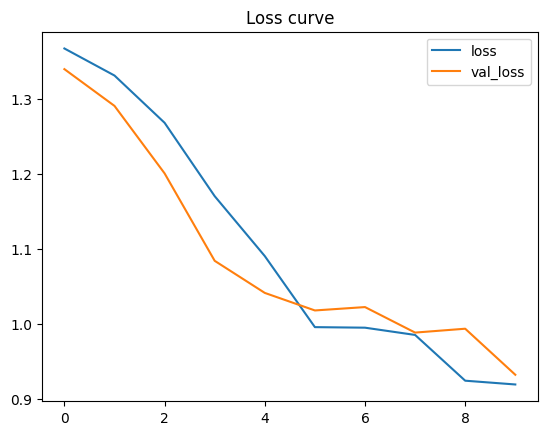

In [341]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

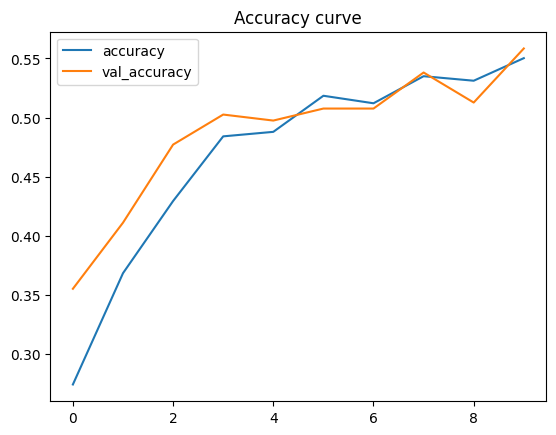

In [342]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [343]:
result = model_3.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

7/7 [==============================] - 0s 6ms/step - loss: 0.9322 - accuracy: 0.5584
[+] Accuracy: 55.84%


In [344]:
result = model_2.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

7/7 [==============================] - 0s 5ms/step - loss: 0.5951 - accuracy: 0.8274
[+] Accuracy: 82.74%


In [345]:
result = model_1.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

7/7 [==============================] - 0s 5ms/step - loss: 0.3978 - accuracy: 0.8629
[+] Accuracy: 86.29%


In [346]:
# from keras.models import Model
# model.save('my_model_steel.keras')

In [347]:
# from keras.models import load_model
# loaded_model = load_model('my_model.h5')

# Архитектура созданной нейронной сети

In [348]:
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 118, 118, 32)      896       
                                                                 
 flatten_10 (Flatten)        (None, 445568)            0         
                                                                 
 dense_21 (Dense)            (None, 4)                 1782276   
                                                                 
Total params: 1783172 (6.80 MB)
Trainable params: 1783172 (6.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [349]:
model_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 39, 39, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 48672)             0         
                                                                 
 dense_22 (Dense)            (None, 256)               12460288  
                                                                 
 dense_23 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 12462212 (47.54 MB)
Trainable params: 12462212 (47.54 MB)
Non-trainable params: 0 (0.00 Byte)
___________

In [350]:
model_3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 39, 39, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 12, 12, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 2, 2, 64)        

# Тестирование на новых примерах

In [351]:
l2[:5]

[3, 3, 3, 1, 3]

In [352]:
X= np.array(l1[:5])
X = X/255

y = encoder.fit_transform(l2[:5])
y = np.array(y)

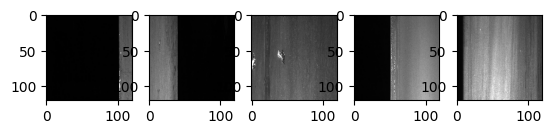

In [353]:
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(l1[i])
plt.show()

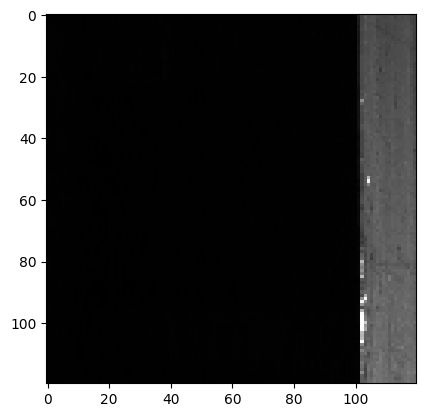

In [354]:
plt.imshow(l1[0]);

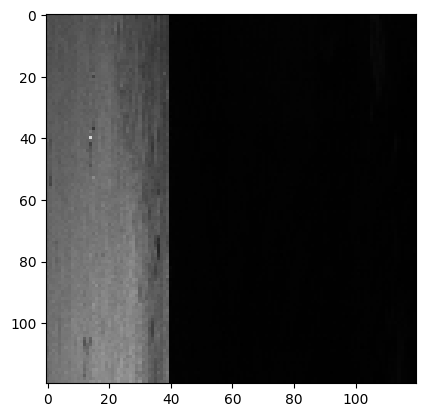

In [355]:
plt.imshow(l1[1]);

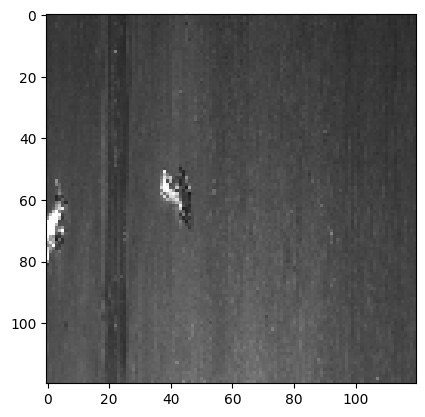

In [356]:
plt.imshow(l1[2]);

In [ ]:
y = encoder.fit_transform(l2[:5])
y

In [ ]:
y =  to_categorical(y)
y

In [ ]:
predictions = model_3.predict(X)
predictions

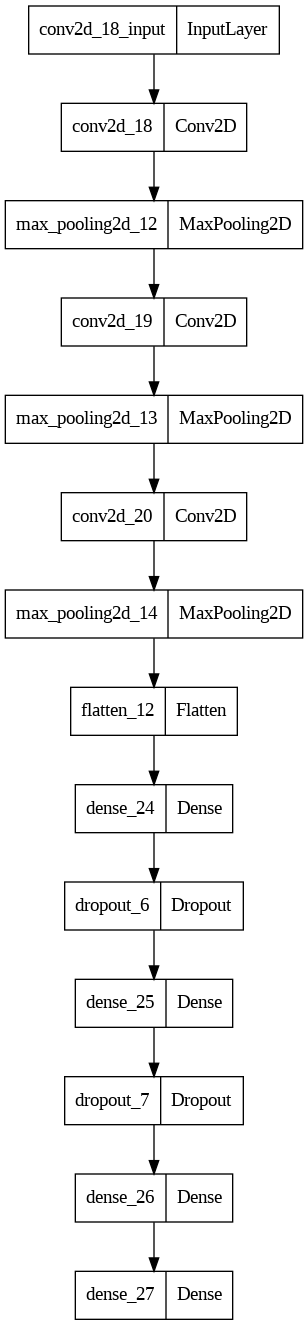

In [360]:
keras.utils.plot_model(model_3)

# Описание архитектуры нейронной сети

У нас тут многослойная нейронная сеть с разными типами слоев.

теперь по поводу слоев нейронной сети и их особенностей.

1 слой - Conv2D. Он используется для выполнения двумерной свертки входных данных. Он применяет набор фильтров к входному изображению или карте объектов, перемещая их по входным данным и вычисляя скалярное произведение в каждом месте. Эта операция позволяет слою извлекать объекты и фиксировать пространственные отношения во входных данных. Уровень Conv2D обычно используется в сверточных нейронных сетях (CNN) для таких задач, как классификация изображений, обнаружение объектов и сегментация изображений.

2 слой - MaxPooling2D.  Это  операция понижающей дискретизации, которая уменьшает пространственные размеры (ширину и высоту) входного изображения или карты объектов. Он делит входные данные на непересекающиеся прямоугольники и выводит максимальное значение внутри каждого прямоугольника. Это помогает извлечь наиболее важные функции и снизить вычислительные требования для последующих слоев.

Далее эти слои повторяются еще 2 раза.

7 слой - Flatten. он преобразует входной тензор в одномерный массив, эффективно выравнивая его. Он принимает многомерный входной тензор, например двумерное изображение, и преобразует его в одномерный вектор, который можно использовать в качестве входных данных для полностью связного слоя или любого другого слоя, который ожидает одномерных входных данных.

8 слой - Dense. это полностью связный слой, который соединяет каждый нейрон предыдущего слоя с каждым нейроном текущего слоя. Он выполняет линейную операцию над входными данными, за которой следует функция активации, позволяющая сети изучать сложные закономерности и взаимосвязи в данных. Количество нейронов в плотном слое определяет размерность вывода.

9 cлой - Dropout. это метод регуляризации, используемый для уменьшения переобучения в нейронных сетях. Он случайным образом устанавливает для части входных единиц значение 0 на каждом этапе обучения, что помогает предотвратить слишком большую зависимость сети от конкретных функций или корреляций. Dropout улучшает способность модели к обобщению за счет внесения шума во время обучения и побуждает сеть изучать более надежные и независимые представления.

Далее слои повторяются.

В итоге в данной нейронной сети 12 различных слоев, и 139 780 параметров.